# Face Mask Segmentation using Computer Vision by Sudha Balasubramanian

# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face Mask Segmentation
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.


## Project Description
The goal is to build a Face Mask Segmentation model which includes building a face detector to locate the position of a face in an image.

## Data Description
**WIDER Face Dataset** - WIDER FACE dataset is a Face Mask Segmentation benchmark dataset, of which images are selected from the publicly available WIDER dataset. This data have 32,203 images and 393,703 faces are labeled with a high degree of variability in scale, pose and occlusion as depicted in the sample images. In this project, we are using 409 images and around 1000 faces for ease of computation. 

We will be using transfer learning on an already trained model to build our segmenter. We will perform transfer learning on the MobileNet model which is already trained to perform image segmentation. We will need to train the last 6-7 layers and freeze the remaining layers to train the model for face mask segmentation. To be able to train the MobileNet model for face mask segmentation, we will be using the WIDER FACE dataset for various images with a single face and multiple faces. The output of the model is the face mask segmented data which masks the face in an image. We learn to build a face mask segmentation model using Keras supported by Tensorflow. 

## Steps and Tasks
1. Load the dataset given in form .npy format. 
   * We have already extracted the images from wider face-dataset and added it in the file images.npy. You can directly use this file for this project. 
   * “images.npy” contains details about the image and it’s masks, there is no separate CSV file for that. 
   * There is no separate train and test data given. 
2. Create Features(images) and labels(mask) using that data. 
3. Load the pre-trained model and weights. 
4. Create a model using the above model. 
5. Define the Dice Coefficient and Loss function. 
6. Compile and fit the model. 
7. Evaluate the model. 

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Change current working directory to project folder (1 mark)

### Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import os
import argparse
import scipy.io as sio
import h5py

import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
import pickle
import keras
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
import keras.backend as K


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


### Set the project path

In [0]:
project_path = '/content/drive/My Drive/Face Mask Segmentation/'

### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [10]:
data_path = project_path + 'images.npy'
data = np.load(data_path, allow_pickle=True)
label = data[:, -1]
img = np.delete(data, -1, axis=1)
print(data.shape)

(409, 2)


### Check one sample from the loaded "images.npy" file  (2 marks)
Hint - print data[10][1] 

In [9]:
#Both variations would give same output
print(data[10,1])
data[10][1]

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.48, 'y': 0.10385756676557864}, {'x': 0.7716666666666666, 'y': 0.6795252225519288}], 'imageWidth': 600, 'imageHeight': 337}]


[{'imageHeight': 337,
  'imageWidth': 600,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.48, 'y': 0.10385756676557864},
   {'x': 0.7716666666666666, 'y': 0.6795252225519288}]}]

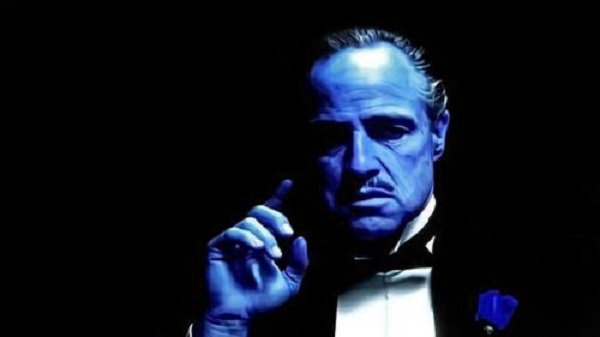

In [11]:
from google.colab.patches import cv2_imshow
cv2_imshow(data[10][0])

### Set image dimensions   (2 marks)
- Initialize image height, image width with value: 224 

In [0]:
ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
CHANNELS = 3

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 224


### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array  (2 marks)

In [14]:
print(X_train.shape, masks.shape)

(409, 224, 224, 3) (409, 224, 224)


### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

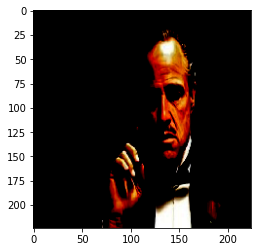

In [15]:
from matplotlib import pyplot
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])

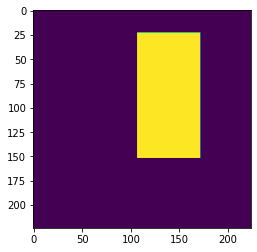

In [11]:
pyplot.imshow(masks[n])

## Train Test Split

In [0]:
# Split train and test
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X_train, masks, test_size=0.15, random_state=20)

In [17]:
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

(347, 224, 224, 3) (62, 224, 224, 3) (347, 224, 224) (62, 224, 224)


## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [18]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, MaxPooling2D, Dropout
from tensorflow.keras.models import Model

IMG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

# Create the base model from the pre-trained model MobileNet 
model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                        include_top=False,
                                        alpha = 1,
                                        weights='imagenet')
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, MaxPooling2D, Dropout
from tensorflow.keras.models import Model


def create_model(trainable=True):
    IMG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

    # Create the base model from the pre-trained model MobileNet 
    model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               alpha = 1,
                                               weights='imagenet')
    
    for layer in model.layers:
        layer.trainable = trainable
    # getting the layers from mobilenet network
    conv_pw_13_relu = model.get_layer("conv_pw_13_relu").output
    conv_pw_11_relu = model.get_layer("conv_pw_11_relu").output
    conv_pw_10_relu = model.get_layer("conv_pw_10_relu").output
    conv_pw_9_relu = model.get_layer("conv_pw_9_relu").output
    conv_pw_8_relu = model.get_layer("conv_pw_8_relu").output
    conv_pw_7_relu = model.get_layer("conv_pw_7_relu").output
    conv_pw_6_relu = model.get_layer("conv_pw_6_relu").output
    conv_pw_5_relu = model.get_layer("conv_pw_5_relu").output
    conv_pw_4_relu = model.get_layer("conv_pw_4_relu").output
    conv_pw_3_relu = model.get_layer("conv_pw_3_relu").output
    conv_pw_2_relu = model.get_layer("conv_pw_2_relu").output
    conv_pw_1_relu = model.get_layer("conv_pw_1_relu").output

    input_1 = model.layers[0].output

    # Adding Unet layers
    # Each set will have 1 upsampling, then concat with the mobilenet layers having same shape
    # followed by 2 conved layers with extra parameters

    up2 = UpSampling2D()(conv_pw_13_relu)
    concat1 = Concatenate()([up2, conv_pw_11_relu])
    new_conv15 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(concat1)
    new_conv15 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(new_conv15)

    up3 = UpSampling2D()(concat1)
    concat2 = Concatenate()([up3, conv_pw_5_relu])
    new_conv16 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(concat2)
    new_conv16 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(new_conv16)

    up4 = UpSampling2D()(concat2)
    concat3 = Concatenate()([up4, conv_pw_3_relu])
    new_conv17 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(concat3)
    new_conv17 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(new_conv17)

    up5 = UpSampling2D()(concat3)
    concat4 = Concatenate()([up5, conv_pw_1_relu])
    new_conv17 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(concat4)
    new_conv17 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(new_conv17)

    up6 = UpSampling2D()(concat4)
    concat5 = Concatenate()([up6, input_1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(concat5)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    model.save('face_mask_segmentation.h5')
    
    return Model(inputs=model.input, outputs=x)

### Call the create_model function

In [20]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
______________________________________________________________________________________________

### Define dice coefficient function (10 marks)
- Create a function to calculate dice coefficient


In [0]:
def dice_coefficient(y_true, y_pred):
    '''
    Function to calculate dice coefficient
    
    Parameters
    ----------
    y_true : numpy array of actual masks
    y_pred : numpy array of predicted masks
    
    Returns
    -------
    dice coefficient
    '''
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

### Define loss

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (3 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [0]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient,'accuracy'])

### Define checkpoint and earlystopping

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model (3 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [29]:
EPOCHS = 10
BATCH_SIZE = 1
PATIENCE = 10
THREADS = 1

history = model.fit(x_train, y_train, 
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpoint, reduce_lr, stop],
                    use_multiprocessing=False,
                    shuffle=True,
                    verbose=1)

Epoch 1/10
347/347 [==============================] - ETA: 0s - loss: 0.4306 - dice_coefficient: 0.7718 - accuracy: 0.0021
Epoch 00001: loss improved from inf to 0.43058, saving model to model-0.43.h5
347/347 [==============================] - 44s 126ms/step - loss: 0.4306 - dice_coefficient: 0.7718 - accuracy: 0.0021 - val_loss: 0.9033 - val_dice_coefficient: 0.5816 - val_accuracy: 9.3606e-04 - lr: 1.0000e-04
Epoch 2/10
347/347 [==============================] - ETA: 0s - loss: 0.3554 - dice_coefficient: 0.8064 - accuracy: 0.0010
Epoch 00002: loss improved from 0.43058 to 0.35539, saving model to model-0.36.h5
347/347 [==============================] - 43s 125ms/step - loss: 0.3554 - dice_coefficient: 0.8064 - accuracy: 0.0010 - val_loss: 0.9894 - val_dice_coefficient: 0.5708 - val_accuracy: 0.0014 - lr: 1.0000e-04
Epoch 3/10
347/347 [==============================] - ETA: 0s - loss: 0.3242 - dice_coefficient: 0.8225 - accuracy: 0.0025
Epoch 00003: loss improved from 0.35539 to 0.3241

In [30]:
print('\nModel Performance: Log Loss and Accuracy on validation data')
print(model.evaluate(x_valid, y_valid, batch_size = 1))


Model Performance: Log Loss and Accuracy on validation data
62/62 [==============================] - 3s 49ms/step - loss: 0.9899 - dice_coefficient: 0.5826 - accuracy: 0.0014
[0.9898866415023804, 0.5825957655906677, 0.001440092222765088]


In [0]:
def plot_model_history(history):
    """
    Function to plot training and validation data of model
     
    """
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['dice_coefficient'])
    plt.plot(history.history['val_dice_coefficient'])
    plt.title('model dice coefficient')
    plt.ylabel('dice_coefficient')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

dict_keys(['loss', 'dice_coefficient', 'accuracy', 'val_loss', 'val_dice_coefficient', 'val_accuracy', 'lr'])


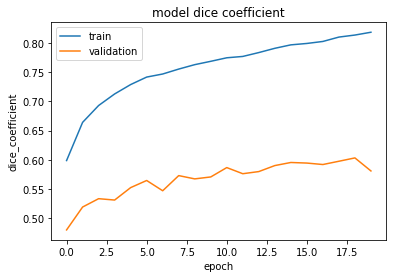

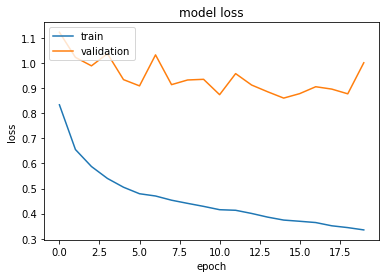

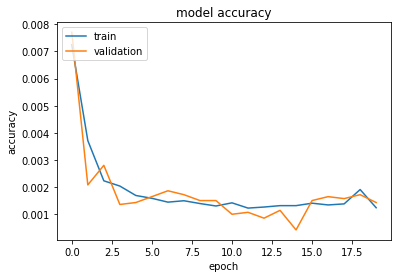

In [26]:
plot_model_history(history)

### Get the predicted mask for a sample image   (5 marks)

In [32]:
### Sample image prediction
n = 10
sample_image = x_valid[n]
image = cv2.resize(sample_image, (IMAGE_WIDTH, IMAGE_HEIGHT))

### Preprocessing the image input
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Prediction
predMask = model.predict(x=np.array([feat_scaled]))[0]
predMask

array([[6.9152875e-08, 6.9152875e-08, 2.9962234e-08, ..., 7.2331693e-07,
        1.0188995e-06, 1.0188995e-06],
       [6.9152875e-08, 6.9152875e-08, 2.9962234e-08, ..., 7.2331693e-07,
        1.0188995e-06, 1.0188995e-06],
       [4.1277712e-08, 4.1277712e-08, 6.2338962e-08, ..., 1.5280018e-06,
        6.8745521e-07, 6.8745521e-07],
       ...,
       [2.6521001e-14, 2.6521156e-14, 3.9061832e-14, ..., 7.1980544e-10,
        3.0593336e-10, 3.0591235e-10],
       [3.4177732e-14, 3.4177993e-14, 2.0314820e-14, ..., 3.8557668e-10,
        4.8406817e-10, 4.8400356e-10],
       [3.4178054e-14, 3.4178250e-14, 2.0315089e-14, ..., 3.8556419e-10,
        4.8411253e-10, 4.8402482e-10]], dtype=float32)

### Impose the mask on the image (5 marks)

In [0]:
n = 10
sample_image1 = X_train[n]
ft = preprocess_input(np.array(sample_image1, dtype=np.float32))
pred_mask = cv2.resize(1.0*(model.predict(x=np.array([sample_image1]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


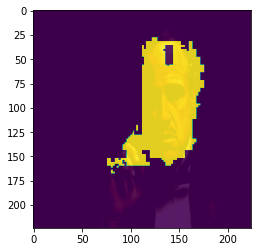

In [39]:
import matplotlib.pyplot as plt
out_image = sample_image1
plt.imshow(out_image)
plt.imshow(pred_mask, alpha=0.9)

In [0]:
def validationImageChecker(xval,yval):
    """
    Function to generate masks for validation images plot it against the
    corresponding ground truth masks
    
    """
    output_msk = np.zeros((len(xval), IMAGE_HEIGHT, IMAGE_WIDTH), dtype=np.uint8)
    idx = 0
    for im in xval:
        xtest = np.array(im)
        xtest=np.expand_dims(xtest, axis=0)
        pred = model.predict(xtest)
        pred = (pred > 0.55).astype(np.uint8)
        pred = np.squeeze(pred[0])
        output_msk[idx]=pred
        idx+=1
    fix, ax = plt.subplots(5,3, figsize=(8,20))
    for i in range(5):
        ax[i,0].set_title(' Actual Image')
        ax[i,0].imshow(xval[i,:,:])
        ax[i,1].set_title(' Actual Mask')
        ax[i,1].imshow(yval[i,:,:])
        ax[i,2].set_title('Predicted Mask')
        ax[i,2].imshow(output_msk[i],cmap='gray')       
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


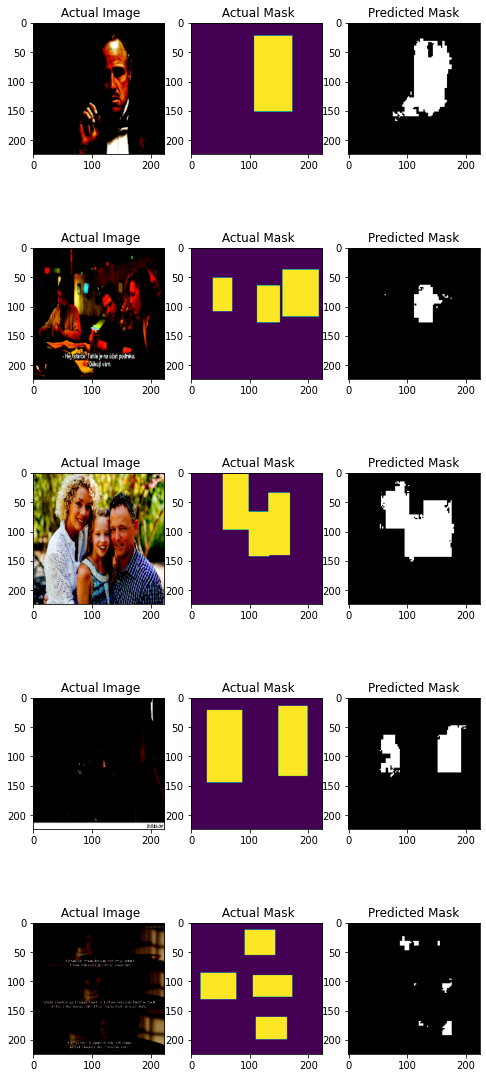

In [34]:
validationImageChecker(x_valid,y_valid)